`Computer vision` 


Kushal Jain   
2019111001

# Assignment 1

## Q1

In [1]:
import numpy as np
import cv2
import warnings
import math
import glob
import matplotlib.pyplot as plt
from random import randint

Implementing the DLT function as told in class.

In [25]:
# given world coordinates and Image coordinates, DLT estimates the p matrix.

def DLT(World, Image):
    M = np.zeros((2 * len(Image), 12))
    # Buiding M matrix
    for i in range(len(Image)):
        M[2 * i][11] = Image[i][0]
        M[2 * i + 1][11] = Image[i][1]
        M[2 * i][3] = M[2 * i + 1][7] = -1
        for j in range(4):
            M[2 * i + 1][j] = M[2 * i][4 + j] = 0
        for j in range(3):
            M[2 * i][j] = -World[i][j]
            M[2 * i + 1][4 + j] = -World[i][j]
            M[2 * i][8 + j] = Image[i][0] * World[i][j]
            M[2 * i + 1][8 + j] = Image[i][1] * World[i][j]

    # SVD to find U, S, V matrices
    U, S, V = np.linalg.svd(M)
    # Finding projection matrix
    P = V[11].reshape((3, 4))
    return P

## Q2

Implementation of RANSAC algorithm for eastimating caliberation matrix

In [26]:
def RANSAC(itr, worldCoords, imageCoords):
    # Best loss
    bestError = math.inf
    # best projection matrix
    bestProjectionMatrix = None

    # iterate itr times
    for _ in range(itr):
        # Getting random k distinct indices
        indices = np.array(range(len(worldCoords)))
        np.random.shuffle(indices)
        indices = indices[:6]

        # Getting coords at those indices
        newWorld, newImage = [], []
        for i in indices:
            newImage.append(imageCoords[i])
            newWorld.append(worldCoords[i])

        # Applying DLT
        P = DLT(newWorld, newImage)
        worldCoordsHomogenous = np.hstack((worldCoords, np.ones((worldCoords.shape[0], 1)))).T

          # Apply projection matrix
        output = np.dot(P, worldCoordsHomogenous)


          # Converting to normal form
        output[:2] /= output[2]
        output = output[:2]

          # Finding error
        error = np.sum((output - imageCoords.T) ** 2) / imageCoords.shape[0]
        error = np.sqrt(error)        
        
        if error < bestError:
            bestError = error
            bestProjectionMatrix = P

    return bestError, bestProjectionMatrix

## Q3

implementing DLT and RANSAC on the given image.

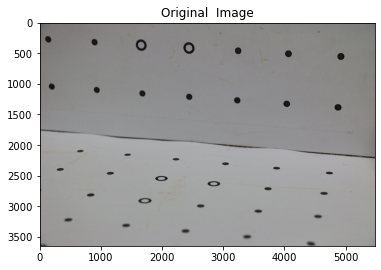

In [27]:
# Plotting the img
cb = cv2.imread('data/black-dots.JPG')
# Converting BGR to RGB
cb = cv2.cvtColor(cb, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (6, 8))
plt.title("Original  Image")
plt.imshow(cb)
plt.show()

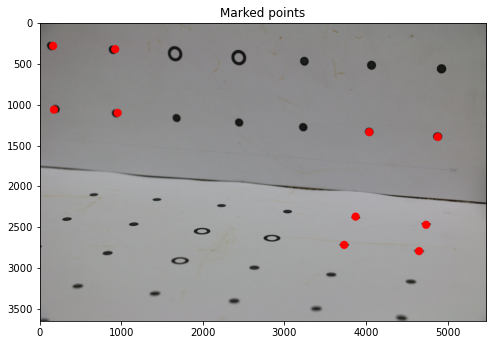

In [81]:
# Coordinates
worldCoords =[[216,72,0],[180,72,0],[216,36,0],[180,36,0] ,[36,36,0],
[0,36,0],[36,0,36],[0,0,36],[36,0,72],[0,0,72]]
imageCoords = [[160,280],[920,320],[170,1060],[950,1100],[4030,1336],
[4869,1394],
[3863,2370],
[4726,2470],
[3723,2716],
[4640,2792]]

worldCoords = np.array(worldCoords)
imageCoords = np.array(imageCoords)

# Mark image coords on image
cb = cv2.imread('data/black-dots.JPG')
# Converting BGR to RGB
cb = cv2.cvtColor(cb, cv2.COLOR_BGR2RGB)
for i in imageCoords:
    cb = cv2.circle(cb, tuple(i), radius=50, color=(255, 0, 0), thickness=-1)

plt.figure(figsize = (8, 10))
plt.title("Marked points")
plt.imshow(cb)
plt.show()

In [82]:
P = DLT(worldCoords, imageCoords)

worldCoordsHomogenous = np.hstack((worldCoords, np.ones((worldCoords.shape[0], 1)))).T

# Apply projection matrix
output = np.dot(P, worldCoordsHomogenous)
output[:2] /= output[2]
output = output[:2]
# print(output)
error = np.sum((output - imageCoords.T) ** 2) / imageCoords.shape[0]
error = np.sqrt(error)  
print("Reconstruction Error :", error)
print("\nProjection Matrix for black dots:\n")
print(P)

Reconstruction Error : 12.462114656240296

Projection Matrix for black dots:

[[-4.02386893e-03 -1.54458697e-04 -2.11429961e-03  9.10812140e-01]
 [-2.46779761e-04 -4.25473331e-03  6.05311258e-04  4.12773537e-01]
 [ 4.53712394e-08 -1.08683880e-07 -3.72867661e-07  1.90203503e-04]]


In [92]:
warnings.filterwarnings('ignore')
bestError, bestProjectionMatrix = RANSAC(1000, worldCoords, imageCoords)
print("Reconstruction Error :", bestError)
print("\nProjection Matrix : \n\n", bestProjectionMatrix)

Reconstruction Error : 15.718238312654936

Projection Matrix : 

 [[ 4.04806157e-03  6.66827958e-05  1.95306417e-03 -9.10157698e-01]
 [ 2.38435129e-04  4.28620083e-03 -6.82968803e-04 -4.14214712e-01]
 [-4.66794011e-08  8.58439361e-08  3.28710605e-07 -1.89530349e-04]]


As we can see root mean square error for DLT is less than that of RANSAC. The reconstruction error isn't stable for a fixed number of iterations due to the randomized nature of the algorithm. As the number of iterations is increased, the error seems to get more accurate and precise. We can see that with just 6 randomly selected points in each iteration we can get a comparable error.

## Q4

Removing distorsions by using `cv2.undistort` and finding out the optimal camera matrix with `cv2.getOptimalNewCameraMatrix`

Distortion Parameters : 
[[ 3.88515350e+00 -5.04221442e+01  6.64220781e-02  2.63352149e-02
   2.15953910e+02]]


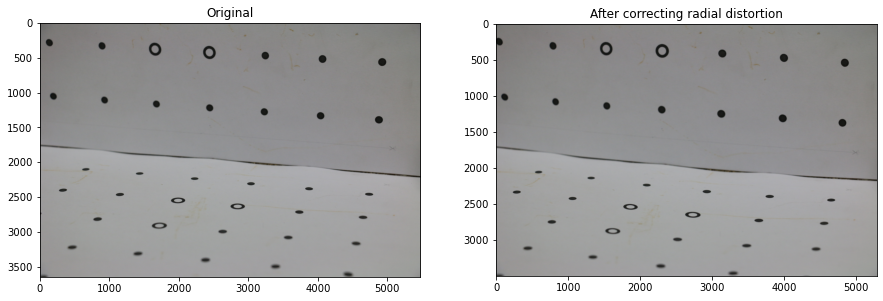

In [37]:
img = cv2.imread('data/black-dots.JPG')
w, h = img.shape[1], img.shape[0]

worldCoords2 =[[216,72,0],[180,72,0],[216,36,0],[180,36,0] ,[36,36,0],
[0,36,0]]
imageCoords2 = [[140,280],[900,320],[180,1060],[950,1100],[4030,1336],
[4869,1394]]
worldCoords2 = np.array(worldCoords2)
imageCoords2 = np.array(imageCoords2)

#performing QR decomposition to get the K, R
R, K = np.linalg.qr(np.linalg.inv(P[:, :3]))
R = R.T
K = np.linalg.inv(K)
K = K/K[-1,-1]

# Converting BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
wc = np.array(worldCoords2.reshape((1,worldCoords2.shape[0], worldCoords2.shape[1]))).astype('float32')
ic = np.array(imageCoords2.reshape((1,imageCoords2.shape[0], imageCoords2.shape[1]))).astype('float32')
K[0,1] = 0
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(wc, ic, (img.shape[1],img.shape[0]), None, None)
print("Distortion Parameters : ")
print(dist)

#refining the camera matrix
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

#undistoring the image and cropping the roi
undist_result1 = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
undist_result = undist_result1[y:y+h, x:x+w]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax[0].imshow(img)
ax[0].title.set_text('Original')
ax[1].imshow(undist_result)
ax[1].title.set_text('After correcting radial distortion')

Calculated distorted parameters and plotted the undistorted image, now applying the caliberation methods on the new image.

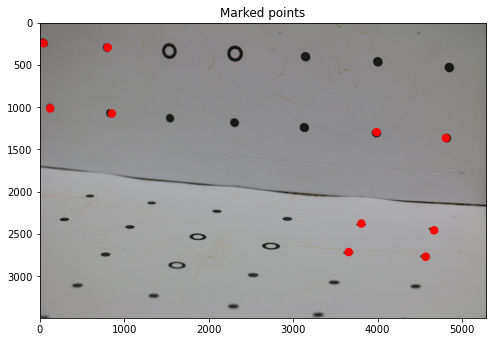

In [89]:
# Coordinates
worldCoords3 =[[216,72,0],[180,72,0],[216,36,0],[180,36,0] ,[36,36,0],
[0,36,0],[36,0,36],[0,0,36],[36,0,72],[0,0,72]]

#corrected points
imageCoords3 = [[40,250],[800,300],[120,1020],[850,1080],[3980,1300],
[4800,1370],
[3800,2380],
[4660,2460],
[3650,2716],
[4560,2772]]

worldCoords3 = np.array(worldCoords3)
imageCoords3 = np.array(imageCoords3)

newimg = np.copy(undist_result)
for i in imageCoords3:
    cb = cv2.circle(newimg, tuple(i), radius=50, color=(255, 0, 0), thickness=-1)

plt.figure(figsize = (8, 10))
plt.title("Marked points")
plt.imshow(cb)
plt.show()

In [90]:
P = DLT(worldCoords3, imageCoords3)

worldCoordsHomogenous = np.hstack((worldCoords3, np.ones((worldCoords3.shape[0], 1)))).T

# Apply projection matrix
output = np.dot(P, worldCoordsHomogenous)
output[:2] /= output[2]
output = output[:2]
# print(output)
error = np.sum((output - imageCoords3.T) ** 2) / imageCoords3.shape[0]
error = np.sqrt(error)  
print("Reconstruction Error :", error)
print("\nProjection Matrix for black dots:\n")
print(P)

Reconstruction Error : 9.04605535939981

Projection Matrix for black dots:

[[ 4.04267332e-03  4.03449633e-04  1.89411883e-03 -9.10958546e-01]
 [ 2.29397034e-04  4.36386397e-03 -8.59756527e-04 -4.12449465e-01]
 [-6.44342202e-08  1.40658173e-07  3.01261964e-07 -1.91697273e-04]]


In [93]:
warnings.filterwarnings('ignore')
bestError2, bestProjectionMatrix2 = RANSAC(1000, worldCoords3, imageCoords3)
print("Reconstruction Error :", bestError2)
print("\nProjection Matrix : \n\n", bestProjectionMatrix2)

Reconstruction Error : 9.57739216834671

Projection Matrix : 

 [[ 4.03521531e-03  4.30286212e-04  1.91862074e-03 -9.10699807e-01]
 [ 2.31501171e-04  4.37330658e-03 -8.29677276e-04 -4.13020347e-01]
 [-6.41759363e-08  1.52141316e-07  3.12486593e-07 -1.92017818e-04]]


### Observation:
Error before and after correction   
DLT -     12.4 -> 9.0  
RANSAC -  15.5 -> 9.5  

- Image now looks undistorted.

- Reconstruction error decreased after correcting radial distortion.

## Q5

Making the wireframe after predicting the points using the P matrix.

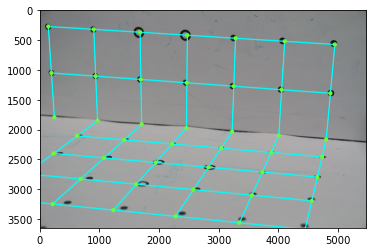

In [39]:
calb_im = cv2.imread('data/black-dots.JPG')
def draw_lines(start,end):
    X1,Y1,Z1 = start
    X2,Y2,Z2 = end
    
    # predict points using P estimated by DLT
    u1,v1,c1 = P.dot([X1,Y1,Z1,1])
    u2,v2,c2 = P.dot([X2,Y2,Z2,1])
    
    #draw lines and points
    cv2.line(calb_im, (int(u1/c1), int(v1/c1)), (int(u2/c2), int(v2/c2)), (0,255,255), 20)
    cv2.circle(calb_im,(int(u1/c1), int(v1/c1)),6,(100,255,55),60)
    cv2.circle(calb_im,(int(u2/c2), int(v2/c2)),6,(100,255,55),60)
for j in range(1,3):
    for i in range(6):
        X1 = i*36
        X2 = (i+1)*36
        Y = j*36
        Z = 0
        draw_lines((X1,Y,Z),(X2,Y,Z))
for i in range(7):
    X = i*36
    Y1 = 36
    Y2 = 72
    Z = 0
    draw_lines((X,Y1,Z),(X,Y2,Z))
for i in range(7):
    X = i*36
    Y1 = 0
    Y2 = 36
    Z = 0
    draw_lines((X,Y1,Z),(X,Y2,Z))
# Out of plane lines
for j in range(4):
    for i in range(6):
        X = i*36
        Y1 = 0
        Y2 = 0
        Z1 = j*36
        Z2 = (j+1)*36
        draw_lines((X,Y1,Z1),(X,Y2,Z2))
# Bottom horizontal lines
for k in range(1,5):
    for i in range(5):
        X1 = i*36
        X2 = (i+1)*36
        Y = 0
        Z = k*36
        draw_lines((X1,Y,Z),(X2,Y,Z))
# Bottom vertical lines
for i in range(6):
    for k in range(1,5):
        X = i*36
        Y = 0
        Z1 = k*36
        Z2 = (k+1)*36
draw_lines((X,Y,Z1),(X,Y,Z2))
plt.imshow(calb_im)

## Q6

Zhangs method

In [123]:
files = glob.glob('./data2/*')

# World coordinates
x,y = np.meshgrid(range(6), range(8))
world = np.hstack((x.reshape(48, 1), y.reshape(48, 1), np.zeros((48, 1)))).astype('float32')

worldpts = []
imagePts = []
for filename in files:
    ret, corners = cv2.findChessboardCorners(cv2.imread(filename), (6, 8))
    if ret:
        imagePts.append(corners)
        worldpts.append(world)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(worldpts, imagePts, (5472, 3648), None, None)
print("Camera Matrix : \n\n", mtx, "\n")
print("Reprojection error : ", ret, "\n")

Camera Matrix : 

 [[1.36634770e+04 0.00000000e+00 3.33653557e+03]
 [0.00000000e+00 1.36813826e+04 1.49660054e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

Reprojection error :  2.481084983813483 



### Observation : 
   - the error is less than that of DLT and RANSAC

## Q7

Making wireframe for zhangs method

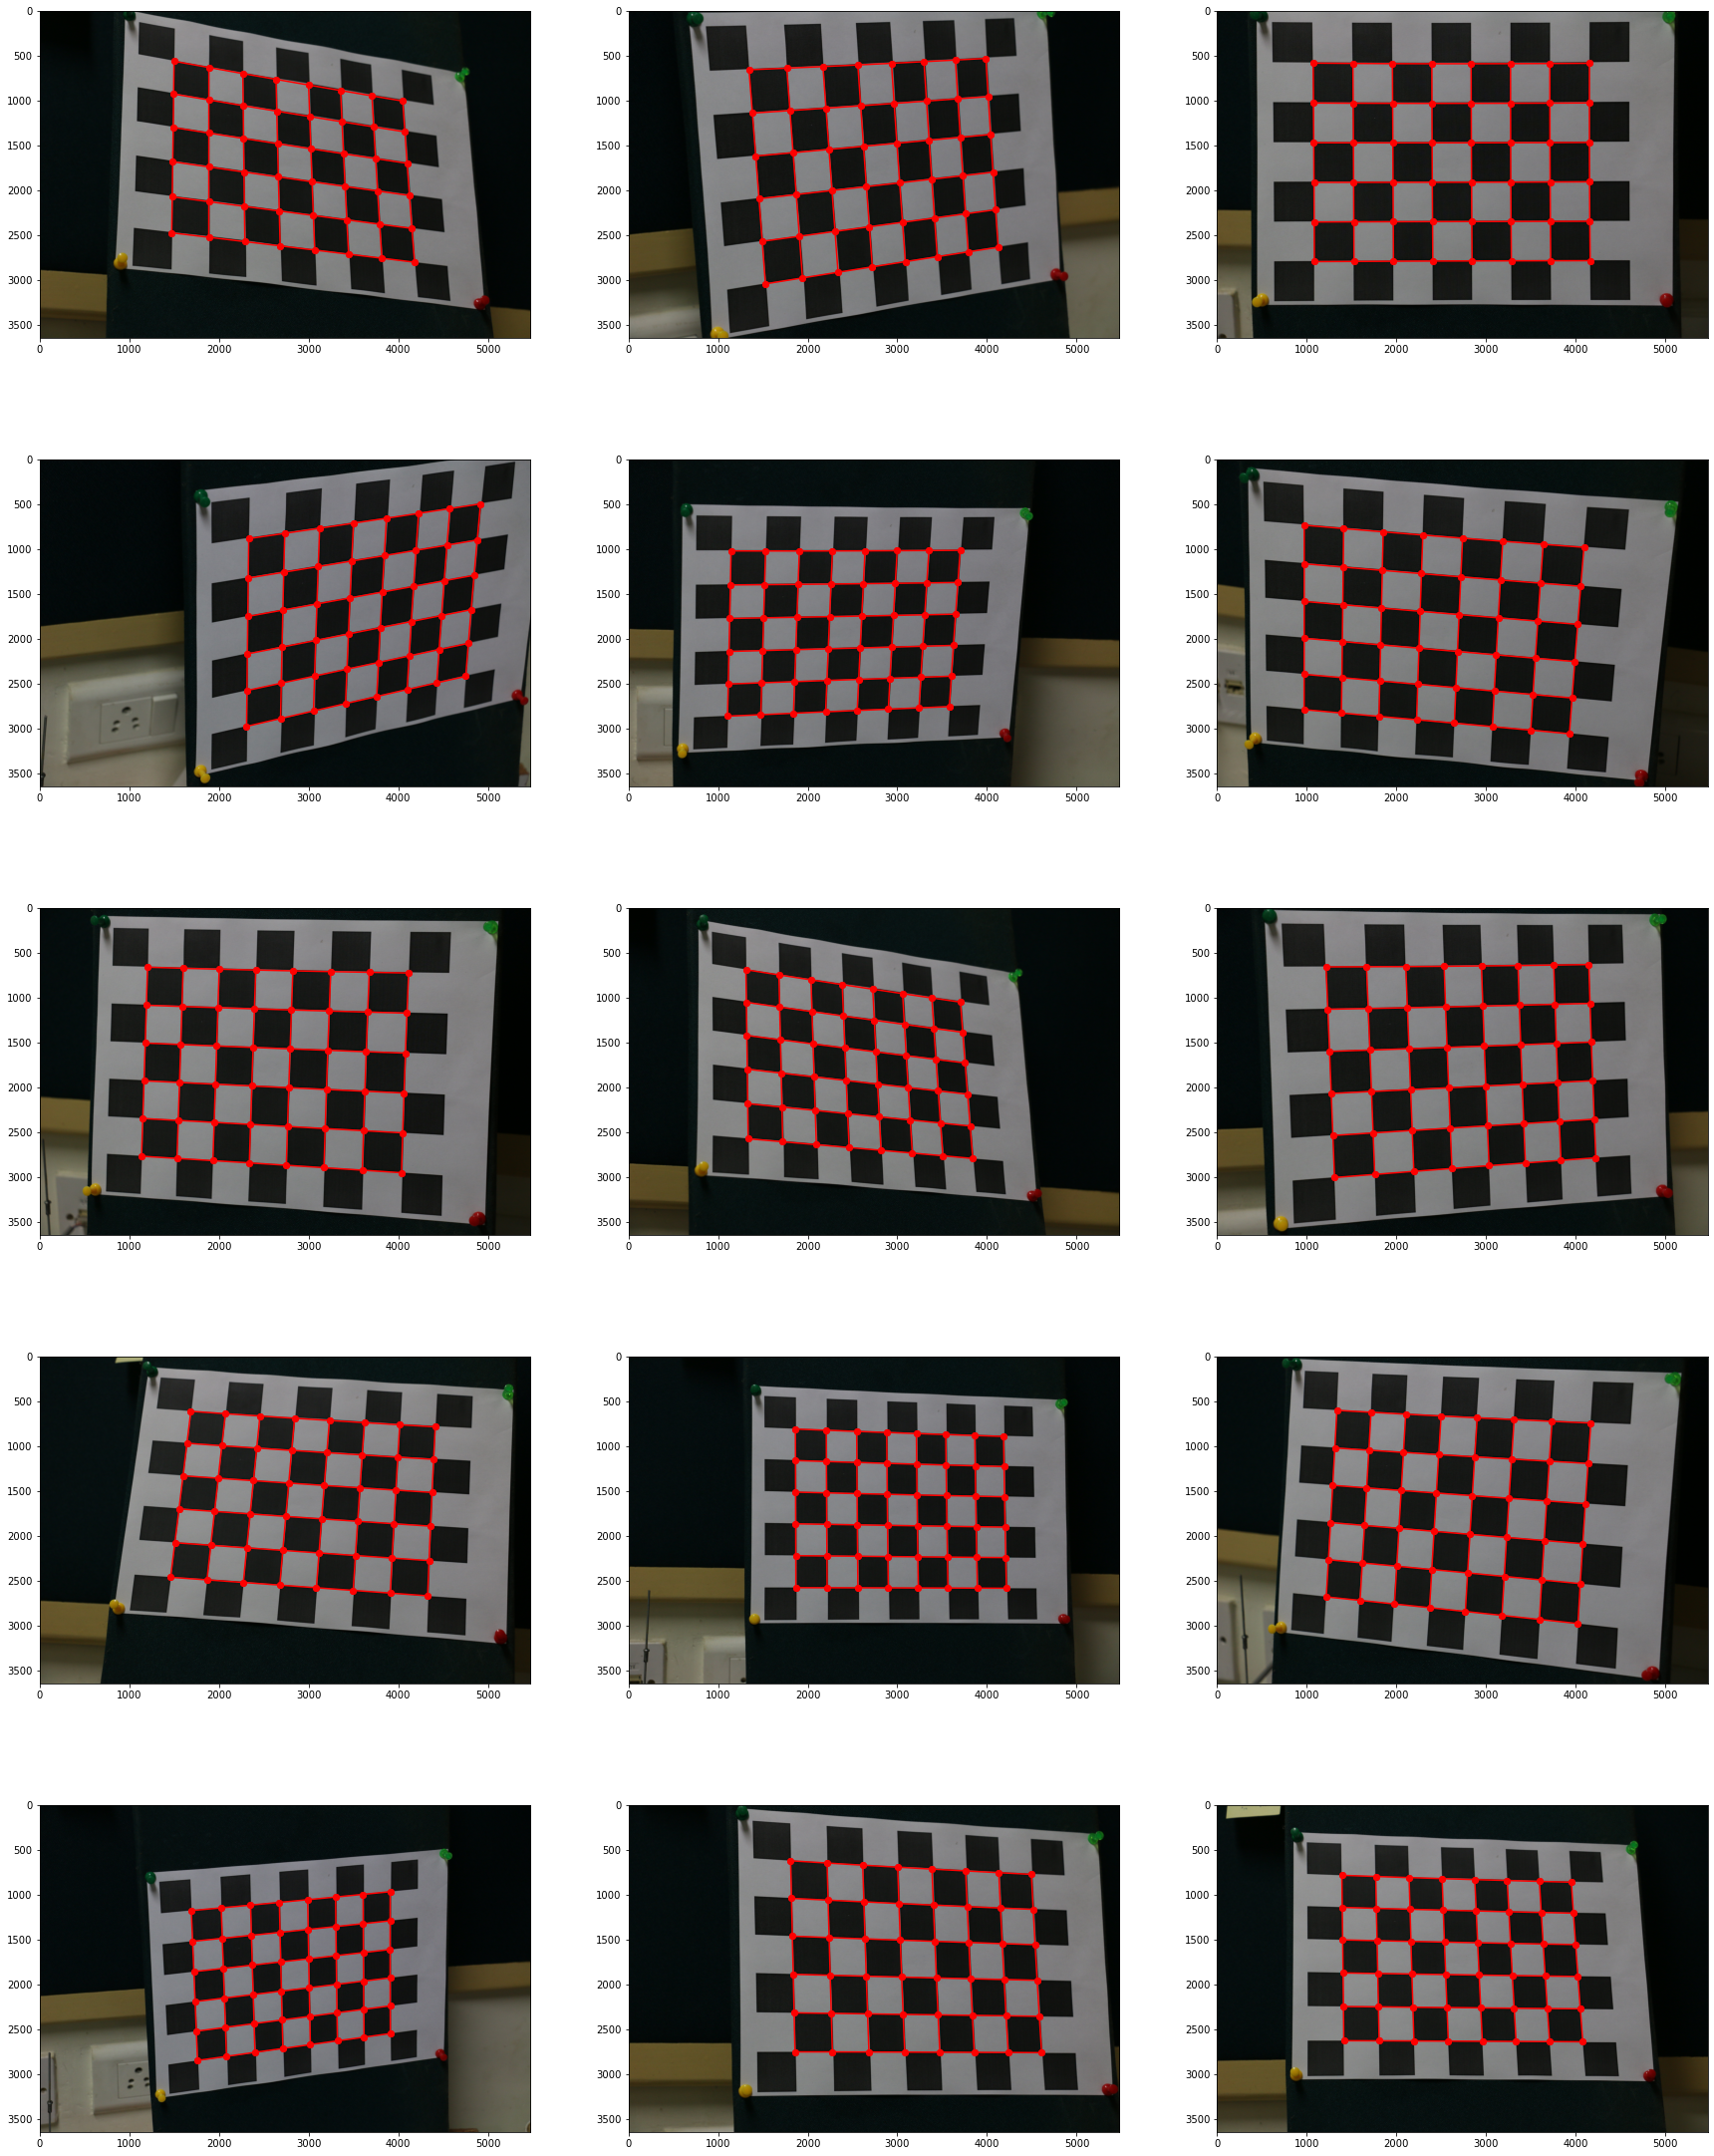

In [125]:
# Predict points
warnings.filterwarnings('ignore')
newPts = []
for i in range(len(worldpts)):
    pred, _ = cv2.projectPoints(worldpts[i], rvecs[i], tvecs[i], mtx, dist)
    newPts.append(pred)

newPts = np.array(newPts).reshape((-1, 2))

plt.figure(figsize=(30, 40))

for i, filename in enumerate(files):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    # Making wireframe
    for j in range(8):
        plt.subplot(5, 3, i + 1).plot(newPts[i * 48 + j * 6:i * 48 + j * 6 + 6, 0], newPts[i * 48 + j * 6:i * 48 + j * 6 + 6, 1], 'ro-')
    for j in range(6):
        indices = np.arange(start=i * 48 + j, stop=(i + 1) * 48 + j, step=6)
        plt.subplot(5, 3, i + 1).plot(newPts[indices][:, 0], newPts[indices][:, 1], 'ro-')

    # Plotting
    plt.subplot(5, 3, i + 1).imshow(img)

### Observations:

- The points coincide with the corners of each checkerboard square.

- The overlay wires coincide with the lines of the checkerboard.

## Q8

Finding the coordinates of image of the origin 

In [77]:
P = DLT(worldCoords, imageCoords)

KR = P[:, :3]
negKRinverse = -np.linalg.inv(KR)
negKRC = P[:, 3]
C = np.dot(-negKRinverse, negKRC)
print('\nprojection center (C):\n')
print(C)


projection center (C):

[  30.56213781 -215.26741162 -530.39229429]


## Q9

I chose to take the photo from my smartphone camera

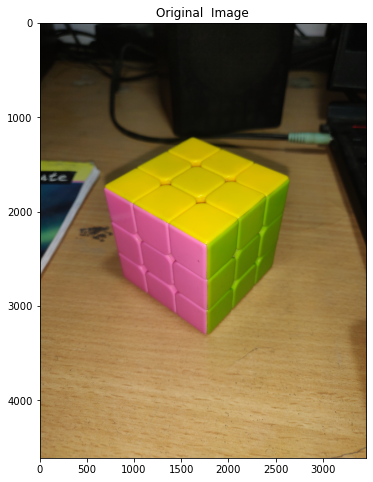

In [8]:
# Plotting the img
cb = cv2.imread('data/my_img.jpg')
# Converting BGR to RGB
cb = cv2.cvtColor(cb, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (6, 8))
plt.title("Original  Image")
plt.imshow(cb)
plt.show()

## Q10

Implementing DLT and RANSAC on the image captured by my camra

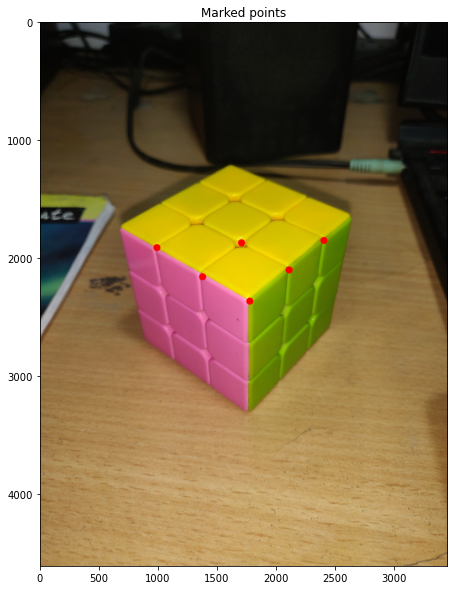

In [10]:
worldCoords =[[0,0,0],[1,0,0],[2,0,0],[0,0,1],[1,0,1],[0,0,2]]
imageCoords = [[1777,2364],[2110,2100],[2405,1850],[1377,2158],[1707,1870],[990,1911]]

worldCoords = np.array(worldCoords)
imageCoords = np.array(imageCoords)
for i in imageCoords:
    cb = cv2.circle(cb, tuple(i), radius=30, color=(255, 0, 0), thickness=-1)
plt.figure(figsize = (8, 10))
plt.title("Marked points")
plt.imshow(cb)
plt.show()

In [13]:
P = DLT(worldCoords, imageCoords)

worldCoordsHomogenous = np.hstack((worldCoords, np.ones((worldCoords.shape[0], 1)))).T

# Apply projection matrix
output = np.dot(P, worldCoordsHomogenous)
output[:2] /= output[2]
output = output[:2]
# print(output)
error = np.sum((output - imageCoords.T) ** 2) / imageCoords.shape[0]
error = np.sqrt(error)  
print("Reconstruction Error :", error)
print("\nProjection Matrix for black dots:\n")
print(P)

Reconstruction Error : 235.25799818537672

Projection Matrix for black dots:

[[-1.40769165e-28 -5.36281273e-17 -1.66973979e-28  1.30439147e-27]
 [-3.46109614e-28 -8.44406826e-13 -7.15130705e-29  1.43936019e-27]
 [-1.25140213e-31 -1.00000000e+00  3.97364613e-32  6.58938940e-31]]


In [15]:
bestError, bestProjectionMatrix = RANSAC(100, worldCoords, imageCoords)
print("Reconstruction Error :", bestError)
print("\nProjection Matrix : \n\n", bestProjectionMatrix)

Reconstruction Error : 9.926699207462368

Projection Matrix : 

 [[ 9.61794464e-28 -3.73988513e-17 -9.87124535e-28  4.49548168e-27]
 [-5.40947583e-28 -8.19116530e-15 -5.47825005e-28  5.99392726e-27]
 [ 7.06048448e-32  1.00000000e+00  1.76027617e-32  2.52488625e-30]]
